In [208]:
import os
import json
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple

palette = sns.color_palette("Set2", 10)

First define the paths where the data is located

In [199]:
train_annotations_path = '/Users/zal/CMU/Spring2017/16824/FinalProject/Data/charades/Charades_vu17_train.csv'
test_annotations_path = '/Users/zal/CMU/Spring2017/16824/FinalProject/Data/charades/Charades_vu17_validation.csv'
classes_path = '/Users/zal/CMU/Spring2017/16824/FinalProject/Data/charades/Charades_v1_classes.txt'
video_len_path = '/Users/zal/CMU/Spring2017/16824/FinalProject/Data/charades/VideoLength.csv'
verb_map_path = '/Users/zal/CMU/Spring2017/16824/FinalProject/Data/charades/Charades_v1_mapping.txt'

Load the action names

In [174]:
action_names = {}
for line in open(classes_path).readlines():
    if line:
        action_id = line[:4]
        action_name = line[5:].strip()
        action_names[action_id] = action_name
print len(action_names.keys())
print action_names['c000']

157
Holding some clothes


Then read the csv file with the annotations

In [175]:
fields_header = 'id,subject,scene,quality,relevance,verified,script,objects,descriptions,actions,length'
fields_list = fields_header.split(',')
fields = {}
for i,field in enumerate(fields_list):
    fields[field]=i

Load the data from the csv

In [176]:
csv_rdr = csv.reader(open(train_annotations_path))
train_annotations = list(csv_rdr)[1:]
print len(train_annotations)
print train_annotations[0][fields['actions']]

7985
c092 11.90 21.20;c147 0.00 12.60


Extract all the actions from the annotations and build the sample tuples

*(id, action, start, end, length)*

In [177]:
def load_actions_from_csv(csv_path, fields):
    csv_rdr = csv.reader(open(csv_path))
    train_annotations = list(csv_rdr)[1:]
    actions_list = []
    for anno in train_annotations:
        video_id = anno[fields['id']]
        if anno[fields['actions']]:
            for action in anno[fields['actions']].split(';'):
                action_id, start, end = action.split(' ')
                actions_list.append((video_id, action_id, float(start), float(end), float(end)-float(start)))

    return actions_list

train_list = load_actions_from_csv(train_annotations_path, fields)
test_list = load_actions_from_csv(test_annotations_path, fields)

print 'The total number of annotations are: {}'.format(len(train_list) + len(test_list))
print 'The train dataset has a total of {} annotated actions.'.format(len(train_list))
print 'The test dataset has a total of {} annotated actions.'.format(len(test_list))

The total number of annotations are: 66500
The train dataset has a total of 49809 annotated actions.
The test dataset has a total of 16691 annotated actions.


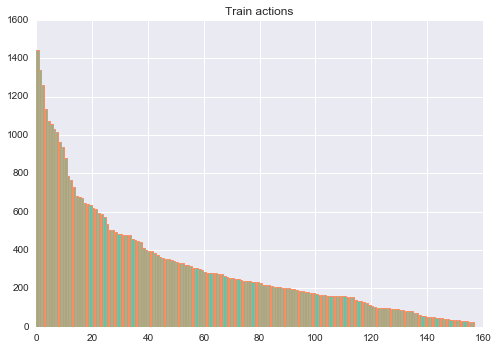

Top 10 actions
(1444)	Walking through a doorway
(1341)	Someone is standing up from somewhere
(1260)	Sitting in a chair
(1134)	Drinking from a cup/glass/bottle
(1075)	Holding some food
(1055)	Holding a phone/camera
(1029)	Someone is smiling
(1014)	Holding a cup/glass/bottle of something
(964)	Someone is going from standing to sitting
(936)	Someone is eating something


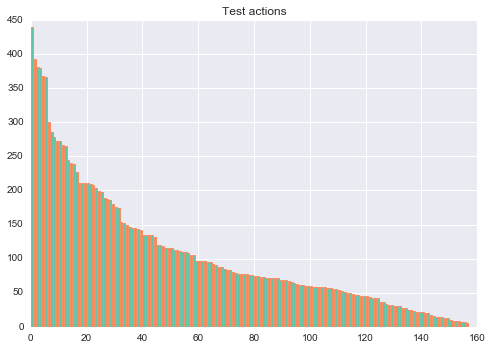

Top 10 actions
(439)	Walking through a doorway
(393)	Someone is smiling
(381)	Someone is standing up from somewhere
(380)	Holding a cup/glass/bottle of something
(368)	Sitting in a chair
(367)	Holding some food
(300)	Drinking from a cup/glass/bottle
(285)	Putting something on a table
(279)	Someone is going from standing to sitting
(273)	Opening a door


In [178]:
def plot_hist_action_list(actions_list, title='Actions',K=10):
    # Count the occurrence of each action
    train_actions_list = zip(*actions_list)[1]
    actions_count = {}
    for action in train_actions_list:
        if action in actions_count:
            actions_count[action] += 1
        else:
            actions_count[action] = 1
    # Prepare count for bar plot: sort and turn to number
    actions_count = sorted(actions_count.items(), key=lambda x:x[1], reverse=True)
    actions, counts = zip(*actions_count)
    counts = [int(c) for c in counts]
    # Plot the sorted 
    plt.clf()
    plt.bar(range(len(counts)), counts, color=palette[0], edgecolor=palette[1], lw=1)
    plt.title(title)
    plt.show()
    print 'Top {} actions'.format(K)
    for action,count in zip(actions[:K], counts[:K]):
        print '({})\t{}'.format(count, action_names[action])

plot_hist_action_list(train_list, 'Train actions')
plot_hist_action_list(test_list, 'Test actions')

Store annotations into file and the frames version:

### Load Video lengths

9848
703
Min len:  57
Max len:  4665
Mean len: 712.917140536
Median len: 734.0
Var len:  48582.6645397


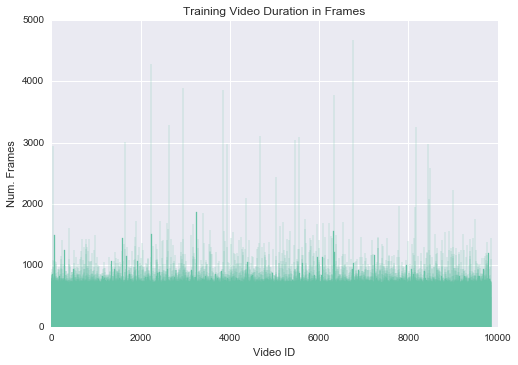

In [222]:
video_length_map = {}
video_length_list = []
len_csv_rdr = csv.reader(open(video_len_path))

for video_id, video_len in len_csv_rdr:
    video_length_map[video_id] = int(video_len)
    video_length_list.append(int(video_len))
    
print len(video_length_map)
print video_length_map['GK6GN'] # must be 703 [frames]

print 'Min len:  {}'.format(min(video_length_list))
print 'Max len:  {}'.format(max(video_length_list))
print 'Mean len: {}'.format(np.mean(video_length_list))
print 'Median len: {}'.format(np.median(video_length_list))
print 'Var len:  {}'.format(np.var(video_length_list))

plt.bar(range(len(video_length_list)), video_length_list, color=palette[0], edgecolor=palette[0])
plt.xlabel('Video ID')
plt.ylabel('Num. Frames')
plt.title('Training Video Duration in Frames')
plt.show()

## Build action map

In [223]:
action_verb_map = {}
verb_csv_rdr = csv.reader(open(verb_map_path), delimiter=' ')
for action_id, _, verb_id in verb_csv_rdr:
    action_verb_map[action_id] = verb_id

In [225]:
FPS = 24
clips_save_path = '/Users/zal/CMU/Spring2017/16824/FinalProject/Data/charades/Action_Clips.csv'
frame_clips_save_path = '/Users/zal/CMU/Spring2017/16824/FinalProject/Data/charades/Action_Clips_Frames.csv'

clips_save_file = open(clips_save_path, 'w')
for clip in actions_list:
    line_output = '%s,%0.3f,%0.3f,%0.3f,%s\n'%(clip[0], clip[2], clip[3], clip[4], clip[1])
    clips_save_file.write(line_output)

frame_clips_save_file = open(frame_clips_save_path, 'w')
for clip in actions_list:    
    video_id = clip[0]
    start_frame = int(clip[2]*FPS)
    end_frame = int(clip[3]*FPS)
    if video_id in video_lengths:
        if video_length_map[video_id] < end_frame:
            end_frame = video_length_map[video_id]  
    else:
        print '{} not found'.format(video_id)
    class_id = action_verb_map[clip[1]]
    line_output = '%s,%d,%d,%d,%s\n'%(video_id, start_frame, end_frame , end_frame - start_frame, class_id)
    frame_clips_save_file.write(line_output)

ZSHWE not found
ZSHWE not found
ZSHWE not found
ZSHWE not found
ZSHWE not found
ZSHWE not found
ZSHWE not found
ZSHWE not found
Z3DBQ not found
Z3DBQ not found
Z3DBQ not found
Z3DBQ not found
Z3DBQ not found
Z3DBQ not found
ZS1P1 not found
ZS1P1 not found
ZS1P1 not found
ZS1P1 not found
ZS1P1 not found
ZS1P1 not found
ZS1P1 not found
ZYVTC not found
ZYVTC not found
ZYVTC not found
ZYVTC not found
ZYVTC not found
ZYVTC not found
ZYVTC not found
ZYVTC not found
ZYVTC not found
ZYVTC not found
ZYVTC not found
ZYVTC not found
ZYVTC not found
ZYVTC not found
ZHLLU not found
ZHLLU not found
ZHLLU not found
ZHLLU not found
ZHLLU not found
ZL7E9 not found
ZL7E9 not found
ZL7E9 not found
ZL7E9 not found
ZL7E9 not found
ZL7E9 not found
ZXHLY not found
ZXHLY not found
ZXHLY not found
ZXHLY not found
ZXHLY not found
ZXHLY not found
ZXHLY not found
Z5JZD not found
Z5JZD not found
Z5JZD not found
Z5JZD not found
Z5JZD not found
Z5JZD not found
Z5JZD not found
Z5JZD not found
Z5JZD not found
Z5JZD no